# Goal of the task

Analyse data extracted from a game. The final goal is to discriminate players that are bad, normal, or good performers. Process and visualise the
data, as well as cluster the players.(cite - Neuroengineer-task.pdf)


### Note:
1. All functions are in utils.py. 

2. Playground is the jupyter notebook I used for playing around with the data and brainstorming ideas. 

3. Task2_final is the jupyter notebook used for the demonstration of the finalised preprocessing steps and model performance 

In [1]:
from utils import extract_features, plot_silhouette
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

### clarification

While looking at the data, I felt that event ID 3 and 2's description might be interchanged. Ie ID 3 has the description 'used pressed green button and the character was not a match' and 2 says 'used pressed red button and the character was not a match'. So according to the description 2 is a hit and 3 is a false alarm or commission error. While looking at the data, I felt that they were interchanged because id 3 had lots of instances and id 2 barely had any. Combining the observation of ID 1 (correct identification or hit) and ID 3 (as per current description) makes it seem like the subjects were only pressing the green button regardless of the trial type. This is an unlikely scenario thus making me think that the ID 2 and 3 descriptions might be interchanged.

Now: HIT = 1 and 3, False Alarm (FA) = 2 and 4, Miss = 5 

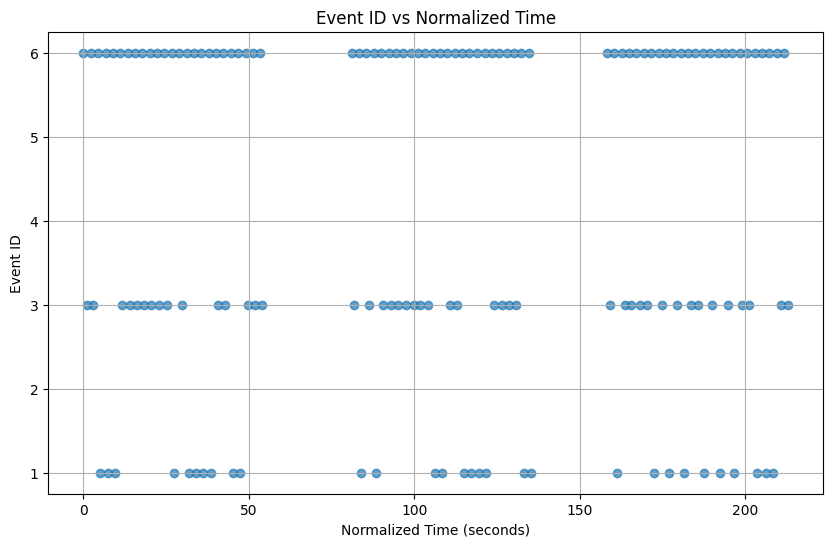

In [2]:
# Directory
file_path = '/home/nayanika/myelin-h/neuroengineering/Metadata-task3/n_back_data/n_back_data/data_43.parquet'

# Read Parquet file into a pandas DataFrame
df = pd.read_parquet(file_path)

# normalize time with respect to the first timestamp
df['normalized_time'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()

plt.figure(figsize=(10, 6))
plt.scatter(df['normalized_time'], df['event_id'], marker='o', alpha=0.7)
plt.xlabel('Normalized Time (seconds)')
plt.ylabel('Event ID')
plt.title('Event ID vs Normalized Time')
plt.grid(True)
plt.show()


In [3]:
directory = '/home/nayanika/myelin-h/neuroengineering/Metadata-task3/n_back_data/n_back_data'
flag = 1

all_features, ID_list = extract_features(directory, flag)

print(ID_list)

['data_0', 'data_1', 'data_10', 'data_11', 'data_12', 'data_13', 'data_14', 'data_15', 'data_16', 'data_17', 'data_18', 'data_19', 'data_2', 'data_20', 'data_21', 'data_22', 'data_23', 'data_24', 'data_25', 'data_26', 'data_27', 'data_28', 'data_29', 'data_3', 'data_30', 'data_31', 'data_32', 'data_33', 'data_34', 'data_35', 'data_36', 'data_37', 'data_38', 'data_39', 'data_4', 'data_40', 'data_41', 'data_43', 'data_44', 'data_45', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9']


## Visualizing all features

The features chosen are 
1. Hit rate
2. False Alarm rate
3. Miss rate
4. Hit latencies

Each metric is calculated for all three levels of the game. So there are a total of 12 features to view.

User ID may not be the real ID. refer to ID_list for for the real order

### obervations



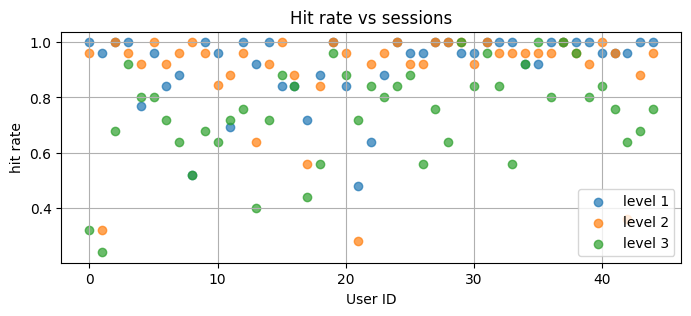

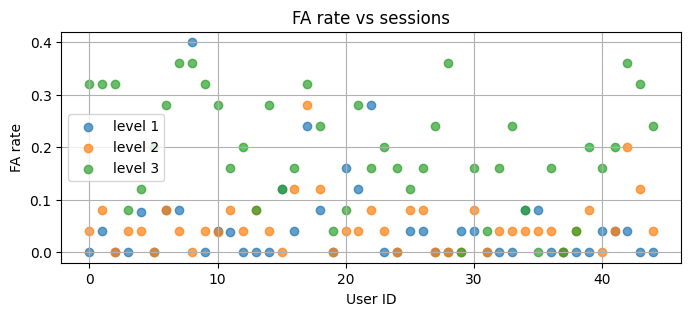

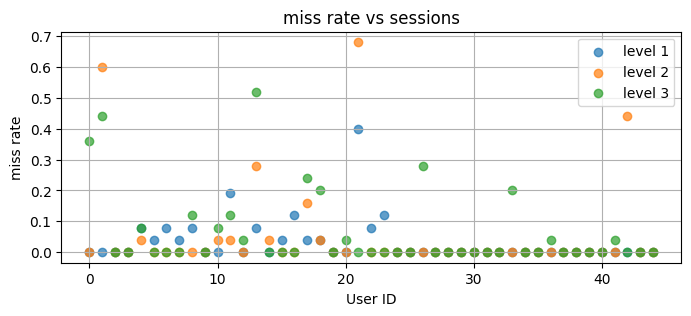

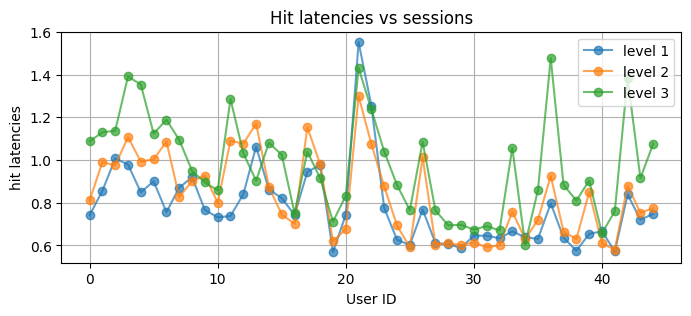

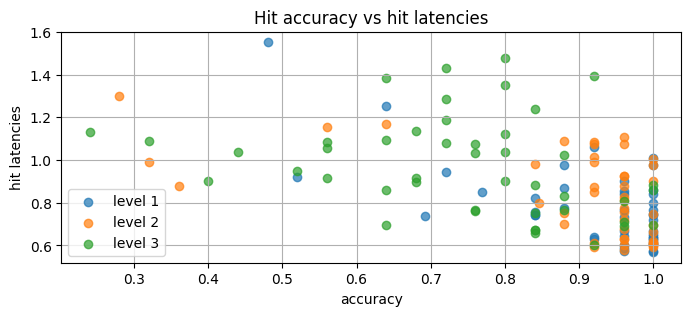

In [4]:
# Plotting
plt.figure(figsize=(8, 3))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7, label="level 1" )
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7, label="level 2")
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7, label="level 3")
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Hit rate vs sessions')
plt.grid(True)
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(8, 3))
plt.scatter(np.arange(45), all_features.loc[3,:], marker='o', alpha=0.7, label="level 1")
plt.scatter(np.arange(45), all_features.loc[4,:], marker='o', alpha=0.7, label="level 2")
plt.scatter(np.arange(45), all_features.loc[5,:], marker='o', alpha=0.7, label="level 3")
plt.xlabel('User ID')
plt.ylabel('FA rate')
plt.title('FA rate vs sessions')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(8, 3))
plt.scatter(np.arange(45), all_features.loc[6,:], marker='o', alpha=0.7, label="level 1")
plt.scatter(np.arange(45), all_features.loc[7,:], marker='o', alpha=0.7, label="level 2")
plt.scatter(np.arange(45), all_features.loc[8,:], marker='o', alpha=0.7, label="level 3")
plt.xlabel('User ID')
plt.ylabel('miss rate')
plt.title('miss rate vs sessions')
plt.grid(True)
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(8, 3))
plt.plot(np.arange(45), all_features.loc[9,:], marker='o', alpha=0.7, label="level 1")
plt.plot(np.arange(45), all_features.loc[10,:], marker='o', alpha=0.7, label="level 2")
plt.plot(np.arange(45), all_features.loc[11,:], marker='o', alpha=0.7, label="level 3")
plt.xlabel('User ID')
plt.ylabel('hit latencies')
plt.title('Hit latencies vs sessions')
plt.grid(True)
plt.legend()
plt.show()

# Plotting
plt.figure(figsize=(8, 3))
plt.scatter(all_features.loc[0,:], all_features.loc[9,:], marker='o', alpha=0.7, label="level 1")
plt.scatter(all_features.loc[1,:], all_features.loc[10,:], marker='o', alpha=0.7, label="level 2")
plt.scatter(all_features.loc[2,:], all_features.loc[11,:], marker='o', alpha=0.7, label="level 3")
plt.xlabel('accuracy')
plt.ylabel('hit latencies')
plt.title('Hit accuracy vs hit latencies')
plt.grid(True)
plt.legend()
plt.show()

### Clustering Model Selection

To Verify the correctness of the clusters, I used 2 classifiers, 3 combinations of features and 2 types of dimensionality reduction

Thus, there are a total of 2*3*(2+1) = 18 combinations.

Each model's performance is verified using visual inspections and silhouette plots.

Similarity between the different clustering methods is also calculated to get an understanding of the performance.

Classifiers - 
1. K means clusters
2. Gaussian Mixture Models

Feature Sets:
1. Hit rate, FA rate, miss rate, Hit latencies
2. Hit rate, FA rate, miss rate
3. Hit rate

Dimensionality Reduction
1. PCA
2. t-SNE 

All individual plots are available in the playground jupyter notebook. 

Using all methods offered only 2 types of clusters that were majorly decided by the feature set.

The model that I finally chose was the PCA,  K means clustering with festures as Hit rate, FA rate, miss rate, Hit latencies.

/home/nayanika/anaconda3/envs/myelin-h/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


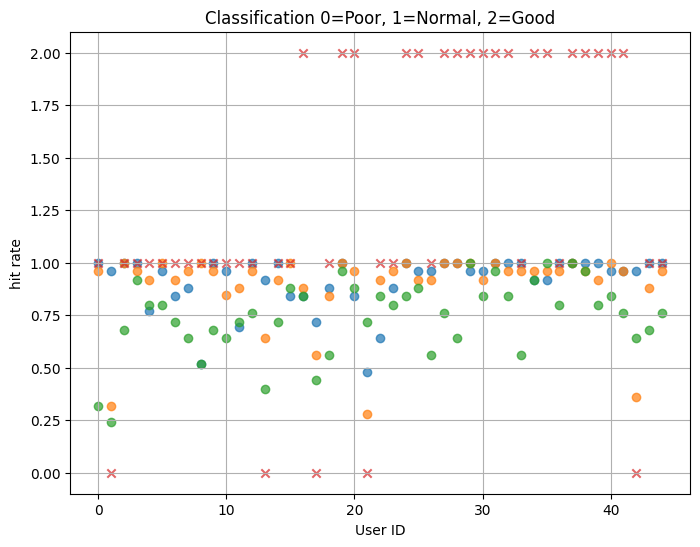

Silhouette Score: 0.6982772625247222


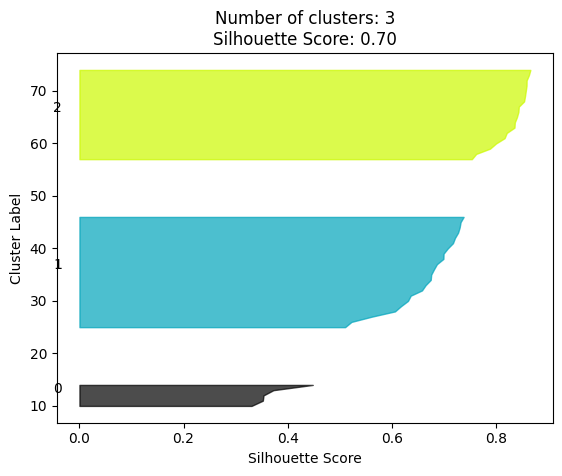

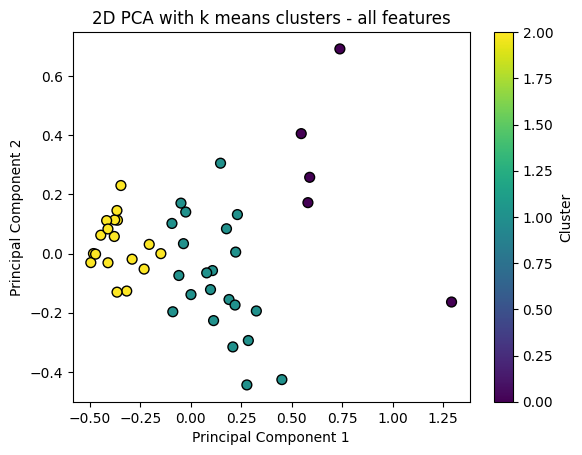

In [5]:
df_transposed = all_features.T

# Perform PCA
num_components = df_transposed.shape[1] 
pca = PCA(n_components=num_components)
df_pca = pca.fit_transform(df_transposed)

# KMeans model
num_clusters = 3  # Adjust as needed
kmeans_model = KMeans(n_clusters=num_clusters, random_state=4)
clusters_km_pca = kmeans_model.fit_predict(df_pca)

df_transposed['Cluster'] = clusters_km_pca

# Mapping
value_mapping = {2: 2, 1: 0, 0: 1}
clusters_km_pca= np.array([value_mapping[value] for value in clusters_km_pca])

# print(clusters_km_pca)

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(45), all_features.loc[0,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[1,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), all_features.loc[2,:], marker='o', alpha=0.7)
plt.scatter(np.arange(45), clusters_km_pca, marker='x', alpha=0.7)
plt.xlabel('User ID')
plt.ylabel('hit rate')
plt.title('Classification 0=Poor, 1=Normal, 2=Good')
plt.grid(True)
plt.show()

plot_silhouette(df_transposed, clusters_km_pca)


# visualize clusters
plot_PCA = pd.DataFrame({'PC1': df_pca[:, 0], 'PC2': df_pca[:, 1], 'Cluster': clusters_km_pca})

plt.figure()
plt.scatter(plot_PCA['PC1'], plot_PCA['PC2'], c=plot_PCA['Cluster'], cmap='viridis', edgecolors='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA with k means clusters - all features')
plt.colorbar(label='Cluster')
plt.show()


In [12]:
final_clusters = list(zip(ID_list, clusters_km_pca)) # except 42

print(final_clusters)

[('data_0', 1), ('data_1', 0), ('data_10', 1), ('data_11', 1), ('data_12', 1), ('data_13', 1), ('data_14', 1), ('data_15', 1), ('data_16', 1), ('data_17', 1), ('data_18', 1), ('data_19', 1), ('data_2', 1), ('data_20', 0), ('data_21', 1), ('data_22', 1), ('data_23', 2), ('data_24', 0), ('data_25', 1), ('data_26', 2), ('data_27', 2), ('data_28', 0), ('data_29', 1), ('data_3', 1), ('data_30', 2), ('data_31', 2), ('data_32', 1), ('data_33', 2), ('data_34', 2), ('data_35', 2), ('data_36', 2), ('data_37', 2), ('data_38', 2), ('data_39', 1), ('data_4', 2), ('data_40', 2), ('data_41', 1), ('data_43', 2), ('data_44', 2), ('data_45', 2), ('data_5', 2), ('data_6', 2), ('data_7', 0), ('data_8', 1), ('data_9', 1)]
